
# EMNIST **byclass** ‚Äî —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–π pipeline (ConvNeXtV2 + —Å–∏–ª—å–Ω—ã–π —Ä–µ—Ü–µ–ø—Ç –æ–±—É—á–µ–Ω–∏—è)

–≠—Ç–æ—Ç –Ω–æ—É—Ç–±—É–∫ –æ–±—É—á–∞–µ—Ç —Ç–æ—á–Ω—É—é –∏ —Å—Ä–∞–≤–Ω–∏—Ç–µ–ª—å–Ω–æ –±—ã—Å—Ç—Ä—É—é –º–æ–¥–µ–ª—å –Ω–∞ **EMNIST (variant: byclass, 62 –∫–ª–∞—Å—Å–∞)** —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã—Ö –ø—Ä–∞–∫—Ç–∏–∫:
- **ConvNeXtV2-Tiny** (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é) c `timm`, –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –æ–±—É—á–µ–Ω–Ω–∞—è –Ω–∞ ImageNet ‚Äî –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –∞–¥–∞–ø—Ç–∏—Ä—É–µ—Ç—Å—è –ø–æ–¥ 1 –∫–∞–Ω–∞–ª;
- **AMP (FP16)** –Ω–∞ CUDA, `torch.compile`, **EMA** –≤–µ—Å–æ–≤, **Label Smoothing**, **Mixup/CutMix**, **Random Erasing**;
- **Cosine LR** —Å **warmup**, **gradient clipping**, `channels_last`;
- –í–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–π —Å–ø–ª–∏—Ç, **–ª—É—á—à–∏–π —á–µ–∫–ø–æ–∏–Ω—Ç**, —Ñ–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ **test**;
- –ö–æ—Ä—Ä–µ–∫—Ç–Ω–∞—è –æ—Ä–∏–µ–Ω—Ç–∞—Ü–∏—è EMNIST (–ø–æ–≤–æ—Ä–æ—Ç -90¬∞ + –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ—Ç—Ä–∞–∂–µ–Ω–∏–µ).
  
> –ü–æ —É–º–æ–ª—á–∞–Ω–∏—é —Ä–µ—Ü–µ–ø—Ç—ã —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω—ã –ø–æ–¥ accuracy / —Å–∫–æ—Ä–æ—Å—Ç—å. –ü—Ä–∏ –∂–µ–ª–∞–Ω–∏–∏ –º–æ–∂–Ω–æ —É—Å–∏–ª–∏—Ç—å –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏, —Ä–∞–∑—Ä–µ—à–µ–Ω–∏–µ –∏ –¥–ª–∏–Ω—É –æ–±—É—á–µ–Ω–∏—è –≤ –±–ª–æ–∫–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏.


In [1]:
# %pip install ipynb

In [2]:

import os, math, time, copy, random
from dataclasses import dataclass
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from IPython.display import clear_output
from torch.utils.data import Dataset
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import pickle

import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy

from torchmetrics.classification import MulticlassAccuracy

In [3]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler


0
None
0
None
0


In [4]:
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

class CustomPickler(pickle.Pickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

In [6]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_RUS.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_RUS.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [7]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("–ö–ª–∞—Å—Å–æ–≤: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

–ö–ª–∞—Å—Å–æ–≤: 76
None


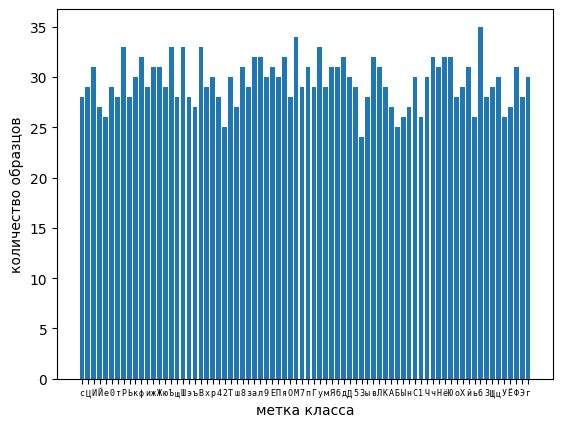

In [8]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xticks( fontsize=6, fontname='monospace')

plt.xlabel("–º–µ—Ç–∫–∞ –∫–ª–∞—Å—Å–∞")
plt.ylabel("–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—Ä–∞–∑—Ü–æ–≤")
plt.savefig("images/rus_dataset.png",  bbox_inches='tight', pad_inches=0)

In [9]:

# %%capture
# –£—Å—Ç–∞–Ω–æ–≤–∏–º –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ (–µ—Å–ª–∏ –Ω—É–∂–Ω–æ). –í Colab / –ª–æ–∫–∞–ª—å–Ω–æ —Å CUDA —ç—Ç–æ –æ–±—ã—á–Ω–æ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ.
# –ü–µ—Ä–µ–∑–∞–ø—É—Å–∫ —Å—Ä–µ–¥—ã –ù–ï —Ç—Ä–µ–±—É–µ—Ç—Å—è.
import sys, subprocess, pkgutil
def pip_install(pkg):
    if pkg not in {m.name for m in pkgutil.iter_modules()}:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for p in ["timm", "torchmetrics"]:
    pip_install(p)

print("‚úÖ –ó–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –≥–æ—Ç–æ–≤—ã.")


‚úÖ –ó–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –≥–æ—Ç–æ–≤—ã.


In [10]:


# Device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Repro
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)


Device: cuda


In [19]:

@dataclass
class CFG:
    data_dir: str = "./data"
    split: str = "byclass"       # –í–ê–ñ–ù–û: –≤–∞—Ä–∏–∞–Ω—Ç EMNIST
    num_classes: int = 76        # byclass = 62 –∫–ª–∞—Å—Å–∞
    img_size: int = 96          # –ú–æ–∂–Ω–æ 96/128/160/192/224; 128 ‚Äî –±—ã—Å—Ç—Ä—ã–π –∏ —Ç–æ—á–Ω—ã–π –∫–æ–º–ø—Ä–æ–º–∏—Å—Å
    batch_size: int = 512        # –ü–æ–¥–±–µ—Ä–∏—Ç–µ –ø–æ–¥ –≤–∞—à—É GPU (–Ω–∞–ø—Ä–∏–º–µ—Ä, 256/384/512/...)
    num_workers: int = 16
    val_ratio: float = 0.05
    epochs: int = 500             # –£–≤–µ–ª–∏—á—å—Ç–µ –¥–æ 20-40 –¥–ª—è –º–∞–∫—Å–∏–º—É–º–∞ –∫–∞—á–µ—Å—Ç–≤–∞
    lr: float = 6e-4             # –±–∞–∑–æ–≤—ã–π LR –ø–æ–¥ AdamW (–±—É–¥–µ—Ç warmup + cosine)
    weight_decay: float = 0.05
    warmup_steps_ratio: float = 0.03  # –¥–æ–ª—è —à–∞–≥–æ–≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ–∫ –Ω–∞ –ª–∏–Ω–µ–π–Ω—ã–π warmup
    min_lr_ratio: float = 0.05        # –ø–æ—Å–ª–µ–¥–Ω–∏–π LR = lr * min_lr_ratio
    grad_clip_norm: float = 2.0
    label_smoothing: float = 0.07
    mixup_alpha: float = 0.2         # 0.0 = –≤—ã–∫–ª; 0.2‚Äì0.4 ‚Äî —Ä–∞–∑—É–º–Ω–æ
    cutmix_alpha: float = 0.0        # –º–æ–∂–Ω–æ 0.5 —Å–æ–≤–º–µ—Å—Ç–Ω–æ —Å mixup
    random_erasing_p: float = 0.1
    weighted_sampling: bool = False   # –í–∫–ª—é—á–∏—Ç–µ, –µ—Å–ª–∏ –∑–∞–º–µ—á–∞–µ—Ç–µ –¥–∏—Å–±–∞–ª–∞–Ω—Å
    ema_decay: float = 0.9997
    use_compile: bool = True
    model_name: str = "convnextv2_tiny"  # –≤–∞—Ä–∏–∞–Ω—Ç—ã: convnextv2_tiny / tf_efficientnetv2_s / resnet50d –∏ –¥—Ä.
    in_chans: int = 1                  # 1 ‚Äî —Å–µ—Ä—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è; timm —É–º–µ–µ—Ç –ø–æ–¥–∫–ª–∞–¥—ã–≤–∞—Ç—å –≤–µ—Å–∞ –∏–∑ 3 –∫–∞–Ω–∞–ª–æ–≤
    fix_emnist_orientation: bool = True
    show_samples: bool = True

cfg = CFG()
print(cfg)


CFG(data_dir='./data', split='byclass', num_classes=76, img_size=96, batch_size=512, num_workers=16, val_ratio=0.05, epochs=500, lr=0.0006, weight_decay=0.05, warmup_steps_ratio=0.03, min_lr_ratio=0.05, grad_clip_norm=2.0, label_smoothing=0.07, mixup_alpha=0.2, cutmix_alpha=0.0, random_erasing_p=0.1, weighted_sampling=False, ema_decay=0.9997, use_compile=True, model_name='convnextv2_tiny', in_chans=1, fix_emnist_orientation=True, show_samples=True)


Train: 2133  |  Val: 112  |  Test: 567


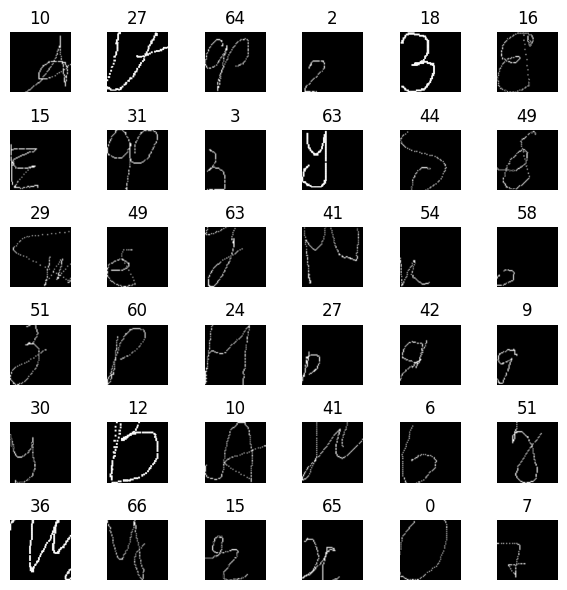

In [20]:

# EMNIST —Ç—Ä–µ–±—É–µ—Ç —Ñ–∏–∫—Å–∞ –æ—Ä–∏–µ–Ω—Ç–∞—Ü–∏–∏ –¥–ª—è "—á–∏—Ç–∞–µ–º–æ–≥–æ" –≤–∏–¥–∞:
# –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–∞—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è (—Å–º. –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏—é EMNIST/torchvision): –ø–æ–≤–µ—Ä–Ω—É—Ç—å -90¬∞ –∏ –æ—Ç—Ä–∞–∑–∏—Ç—å –ø–æ –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª–∏.
def fix_emnist(img):
    img = TF.rotate(img, 180)    # –ø–æ–≤–µ—Ä–Ω—É—Ç—å –Ω–∞ -90 –≥—Ä–∞–¥—É—Å–æ–≤
    img = TF.hflip(img)          # –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω–æ–µ –æ—Ç—Ä–∞–∂–µ–Ω–∏–µ
    return img

# –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ–¥ "–ø—Å–µ–≤–¥–æ-ImageNet" –¥–ª—è 1 –∫–∞–Ω–∞–ª–∞: —Å—Ä–µ–¥–Ω–µ–µ –∏ std —É—Å—Ä–µ–¥–Ω–µ–Ω—ã –ø–æ RGB
IMAGENET_GRAY_MEAN = (0.449,)
IMAGENET_GRAY_STD  = (0.226,)

train_tf_list = []
if cfg.fix_emnist_orientation:
    train_tf_list.append(transforms.Lambda(fix_emnist))

train_tf_list += [
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.Grayscale(num_output_channels=cfg.in_chans),  # –≥–∞—Ä–∞–Ω—Ç–∏—Ä—É–µ–º 1 –∫–∞–Ω–∞–ª
    transforms.RandAugment(num_ops=2, magnitude=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD),
    # transforms.RandomErasing(p=cfg.random_erasing_p, scale=(0.02, 0.25), ratio=(0.3, 3.3), value="random")
]

val_tf_list = []
if cfg.fix_emnist_orientation:
    val_tf_list.append(transforms.Lambda(fix_emnist))

val_tf_list += [
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.Grayscale(num_output_channels=cfg.in_chans),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD),
]

train_transform = transforms.Compose(train_tf_list)
val_transform = transforms.Compose(val_tf_list)

class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        str="0123456789–ê–ë–í–ì–î–ï–Å–ñ–ó–ò–ô–ö–õ–ú–ù–û–ü–†–°–¢–£–§–•–¶–ß–®–©–™–´–¨–≠–Æ–Ø–∞–±–≤–≥–¥–µ—ë–∂–∑–∏–π–∫–ª–º–Ω–æ–ø—Ä—Å—Ç—É—Ñ—Ö—Ü—á—à—â—ä—ã—å—ç—é—è"
        # str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img=self.data[idx].singleImage()
        array = np.array(img, dtype=np.uint8)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        class_num=self.classes.index(self.data[idx].name)
        return img,class_num
image_datasets = {"train": ImageDataset(TRAIN_DICT,transform=train_transform),
                 "val":ImageDataset(TEST_DICT,transform=val_transform)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes_names = {x: image_datasets[x].classes for x in ['train', 'val']}
        
train_full = image_datasets["train"]
test_set = image_datasets["val"]

n_train = len(train_full)
n_val = int(n_train * cfg.val_ratio)
n_tr  = n_train - n_val

train_set, val_set = random_split(train_full, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

print(f"Train: {len(train_set)}  |  Val: {len(val_set)}  |  Test: {len(test_set)}")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø–∞—Ä—ã —Å—ç–º–ø–ª–æ–≤
if cfg.show_samples:
    import math
    from PIL import Image
    grid_sz = 6
    fig, axes = plt.subplots(grid_sz, grid_sz, figsize=(6,6))
    for ax in axes.ravel():
        idx = random.randrange(len(train_set))
        img, label = train_set[idx]
        # img —Ç–µ–Ω–∑–æ—Ä [C,H,W]; –¥–ª—è –ø—Ä–æ—Å–º–æ—Ç—Ä–∞ —Å–≤–µ—Ä–Ω—ë–º –¥–æ HxW
        ax.imshow(img.squeeze().numpy(), cmap="gray")
        ax.set_title(str(label))
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [21]:

def make_weighted_sampler(train_subset: Subset, num_classes: int) -> Optional[WeightedRandomSampler]:
    # –°–æ–±–∏—Ä–∞–µ–º labels –∏–º–µ–Ω–Ω–æ –Ω–∞ –ø–æ–¥–º–Ω–æ–∂–µ—Å—Ç–≤–µ train_set
    base_ds = train_subset.dataset  # —ç—Ç–æ train_full (EMNIST train)
    all_targets = torch.as_tensor(base_ds.targets, dtype=torch.long)
    subset_idx = torch.as_tensor(train_subset.indices, dtype=torch.long)
    labels = all_targets.index_select(0, subset_idx)
    counts = torch.bincount(labels, minlength=num_classes).float()
    inv_freq = 1.0 / (counts + 1e-9)
    sample_weights = inv_freq[labels]
    return WeightedRandomSampler(weights=sample_weights.double(),
                                 num_samples=len(sample_weights),
                                 replacement=True)

sampler = make_weighted_sampler(train_set, cfg.num_classes) if cfg.weighted_sampling else None

train_loader = DataLoader(train_set, batch_size=cfg.batch_size,
                          shuffle=(sampler is None), sampler=sampler,
                          num_workers=cfg.num_workers, pin_memory=True, persistent_workers=True)

val_loader   = DataLoader(val_set, batch_size=cfg.batch_size*2,
                          shuffle=False, num_workers=cfg.num_workers,
                          pin_memory=True, persistent_workers=True)

test_loader  = DataLoader(test_set, batch_size=cfg.batch_size*2,
                          shuffle=False, num_workers=cfg.num_workers,
                          pin_memory=True, persistent_workers=True)

steps_per_epoch = math.ceil(len(train_loader))
total_train_steps = steps_per_epoch * cfg.epochs
warmup_steps = int(total_train_steps * cfg.warmup_steps_ratio)

print(f"Steps/epoch: {steps_per_epoch}, total steps: {total_train_steps}, warmup: {warmup_steps}")


Steps/epoch: 5, total steps: 2500, warmup: 75


In [22]:

# –°–æ–∑–¥–∞—ë–º –º–æ–¥–µ–ª—å —á–µ—Ä–µ–∑ timm –∏ –∞–¥–∞–ø—Ç–∏—Ä—É–µ–º –ø–æ–¥ –æ–¥–∏–Ω –∫–∞–Ω–∞–ª –∏ 62 –∫–ª–∞—Å—Å–∞.
model = timm.create_model(cfg.model_name, pretrained=True, in_chans=cfg.in_chans, num_classes=cfg.num_classes)

# –ö–∞—á–µ—Å—Ç–≤–æ/—Å–∫–æ—Ä–æ—Å—Ç—å —É–ª—É—á—à–∞–µ—Ç channels_last (–Ω–∞ CUDA)
if device == "cuda":
    model = model.to(memory_format=torch.channels_last)

model = model.to(device)

# –û–ø—Ü–∏–æ–Ω–∞–ª—å–Ω–æ torch.compile –¥–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è (PyTorch >= 2.0)
if cfg.use_compile:
    try:
        model = torch.compile(model)
        print("‚úÖ torch.compile –∞–∫—Ç–∏–≤–∏—Ä–æ–≤–∞–Ω")
    except Exception as e:
        print("‚ö†Ô∏è torch.compile –Ω–µ —Å—Ä–∞–±–æ—Ç–∞–ª:", e)

# EMA –∫–æ–Ω—Ç–µ–π–Ω–µ—Ä
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9997, device: Optional[str] = None):
        self.ema = copy.deepcopy(model).eval()
        for p in self.ema.parameters():
            p.requires_grad_(False)
        self.decay = decay
        self.device = device
        if device is not None:
            self.ema.to(device)

    @torch.no_grad()
    def update(self, model: nn.Module):
        d = self.decay
        msd = model.state_dict()
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:
                v.copy_(v * d + msd[k] * (1.0 - d))
            else:
                v.copy_(msd[k])

model_ema = ModelEMA(model, decay=cfg.ema_decay, device=device)

# # –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä, –ª–æ—Å—Å, –º–∏–∫—Å–∞–ø
# optimizer = AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, fused=(device=="cuda"))

use_mixup = (cfg.mixup_alpha > 0.0) or (cfg.cutmix_alpha > 0.0)
if use_mixup:
    mixup_fn = Mixup(mixup_alpha=cfg.mixup_alpha, cutmix_alpha=cfg.cutmix_alpha,
                     label_smoothing=cfg.label_smoothing,
                     num_classes=cfg.num_classes)
    criterion = SoftTargetCrossEntropy()
else:
    mixup_fn = None
    criterion = LabelSmoothingCrossEntropy(smoothing=cfg.label_smoothing)


# # –ú–µ—Ç—Ä–∏–∫–∏
acc1_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc3_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=3).to(device)
acc5_metric_val = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=5).to(device)

acc1_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc3_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=1).to(device)
acc5_metric_test = MulticlassAccuracy(num_classes=cfg.num_classes, top_k=5).to(device)

print("–ú–æ–¥–µ–ª—å:", cfg.model_name)


‚úÖ torch.compile –∞–∫—Ç–∏–≤–∏—Ä–æ–≤–∞–Ω
–ú–æ–¥–µ–ª—å: convnextv2_tiny


In [23]:
# === Patch: –±–µ–∑–æ–ø–∞—Å–Ω—ã–π AdamW + —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π AMP ===
import torch, torch.nn as nn
from contextlib import nullcontext
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1) (–û–ø—Ü–∏–æ–Ω–∞–ª—å–Ω–æ, –Ω–æ –ø–æ–ª–µ–∑–Ω–æ –Ω–∞ NVIDIA) —Ä–∞–∑—Ä–µ—à–∏–º TF32 –¥–ª—è —Å–∫–æ—Ä–æ—Å—Ç–∏
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# 2) –û—Ç–∫–ª—é—á–∞–µ–º fused-—è–¥—Ä–æ —É AdamW -> –∏–∑–±–∞–≤–ª—è–µ–º—Å—è –æ—Ç —Å—Ç—Ä–æ–≥–∏—Ö —Ç—Ä–µ–±–æ–≤–∞–Ω–∏–π –∫ dtype/layout
#    –í–∫–ª—é—á–∞–µ–º foreach (–º—É–ª—å—Ç–∏-—Ç–µ–Ω–∑–æ—Ä–Ω—ã–π –ø—É—Ç—å) ‚Äî –æ–Ω –±—ã—Å—Ç—Ä—ã–π –∏ —É—Å—Ç–æ–π—á–∏–≤—ã–π.
optimizer = AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay,
    fused=False,
    foreach=True
)

# –ü–µ—Ä–µ—Å–æ–∑–¥–∞—ë–º scheduler —Å –Ω–æ–≤—ã–º optimizer
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=max(1, total_train_steps - warmup_steps),
    eta_min=cfg.lr * cfg.min_lr_ratio
)

# 3) –°–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π AMP API (–±–µ–∑ –¥–µ–ø—Ä–µ–∫–µ–π—Ç-–ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏–π)
amp_dtype = (torch.bfloat16 if (device == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16)

def autocast_ctx():
    return torch.amp.autocast(device_type="cuda", dtype=amp_dtype) if device == "cuda" else nullcontext()

scaler = torch.amp.GradScaler(device="cuda", enabled=(device == "cuda"))
import torch.nn.functional as F
from timm.loss import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy

# –¥–≤–∞ –ª–æ—Å—Å–∞:
criterion_soft = SoftTargetCrossEntropy()
criterion_hard = LabelSmoothingCrossEntropy(smoothing=cfg.label_smoothing)
# 4) –ü–µ—Ä–µ–æ–ø—Ä–µ–¥–µ–ª—è–µ–º train_one_epoch c –Ω–æ–≤—ã–º autocast/scaler
def train_one_epoch(epoch: int, global_step: int, scaler):
    model.train()
    running_loss = 0.0
    correct1 = 0
    total = 0
    log_every = max(1, steps_per_epoch // 100)

    for step, (x, y) in enumerate(train_loader):
        # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –±–∞—Ç—á–∏ —Ç–æ–∂–µ channels_last (–Ω–µ–º–Ω–æ–≥–æ —É—Å–∫–æ—Ä—è–µ—Ç –Ω–∞ CUDA)
        x = x.to(device, non_blocking=True)
        if device == "cuda":
            x = x.to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        # Mixup —Ç–æ–ª—å–∫–æ –µ—Å–ª–∏ –±–∞—Ç—á —á—ë—Ç–Ω—ã–π –∏ >=2
        do_mix = (mixup_fn is not None) and (x.size(0) >= 2) and (x.size(0) % 2 == 0)

        if do_mix:
            x, y_mix = mixup_fn(x, y)      # y_mix: [B, num_classes] (soft targets)
            targets_soft = y_mix
        else:
            targets_soft = None            # –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å "–∂—ë—Å—Ç–∫–∏–π" –ª–æ—Å—Å

        with autocast_ctx():
            out = model(x)
            if do_mix:
                loss = criterion_soft(out, targets_soft)   # –º—è–≥–∫–∏–µ —Ü–µ–ª–∏
            else:
                loss = criterion_hard(out, y)              # —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω—ã–µ –º–µ—Ç–∫–∏

        optimizer.zero_grad(set_to_none=True)
        if device == "cuda":
            scaler.scale(loss).backward()
            if cfg.grad_clip_norm:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward()
            if cfg.grad_clip_norm:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            optimizer.step()

        model_ema.update(model)

        # LR warmup + cosine
        global_step += 1
        if global_step <= warmup_steps:
            warmup_lr = cfg.lr * (global_step / max(1, warmup_steps))
            for pg in optimizer.param_groups:
                pg["lr"] = warmup_lr
        else:
            cosine_scheduler.step()

        running_loss += loss.item() * x.size(0)

        if mixup_fn is None:
            preds = out.argmax(dim=1)
            correct1 += (preds == y).sum().item()
            total += y.size(0)

        if (step + 1) % log_every == 0 or (step + 1) == steps_per_epoch:
            if mixup_fn is None and total > 0:
                approx_acc = 100.0 * correct1 / total
                print(f"Epoch {epoch+1} [{step+1}/{steps_per_epoch}]  loss={running_loss/(((step+1)*train_loader.batch_size)):.4f}  acc‚âà{approx_acc:5.2f}%  lr={optimizer.param_groups[0]['lr']:.5f}")
            else:
                print(f"Epoch {epoch+1} [{step+1}/{steps_per_epoch}]  loss={running_loss/(((step+1)*train_loader.batch_size)):.4f}  lr={optimizer.param_groups[0]['lr']:.5f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss, global_step

print("‚úÖ Patched: non-fused AdamW + torch.amp autocast/GradScaler (BF16 if available)")






@torch.no_grad()
def evaluate(loader, use_ema: bool = True):
    model_to_eval = model_ema.ema if use_ema else model
    model_to_eval.eval()

    total_loss = 0.0
    acc1_metric_val.reset()
    acc3_metric_val.reset()
    acc5_metric_val.reset()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        out = model_to_eval(x)
        loss = F.cross_entropy(out, y)
        total_loss += loss.item() * x.size(0)

        acc1_metric_val.update(out, y)
        acc3_metric_val.update(out, y)
        acc5_metric_val.update(out, y)

    n = len(loader.dataset)
    val_loss = total_loss / n
    acc1 = acc1_metric_val.compute().item() * 100.0
    acc3 = acc3_metric_val.compute().item() * 100.0
    acc5 = acc5_metric_val.compute().item() * 100.0
    return val_loss, acc1, acc3, acc5

best_val_acc = 0.0
best_ckpt_path = "models/best_rus_model.pth"
best_is_ema = True

global_step = 0
print("üöÄ –°—Ç–∞—Ä—Ç –æ–±—É—á–µ–Ω–∏—è")
start_time = time.time()

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

train_history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc1": [], "val_acc3": [], "val_acc5": []}

for epoch in range(cfg.epochs):
    train_loss, global_step = train_one_epoch(epoch, global_step, scaler)
    val_loss, val_acc1, val_acc3, val_acc5 = evaluate(val_loader, use_ema=True)

    train_history["epoch"].append(epoch+1)
    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc1"].append(val_acc1)
    train_history["val_acc3"].append(val_acc3)
    train_history["val_acc5"].append(val_acc5)

    print(f"‚úÖ Epoch {epoch+1}: val_loss={val_loss:.4f}  val_acc@1={val_acc1:.2f}%  val_acc@3={val_acc3:.2f}%  val_acc@5={val_acc5:.2f}%")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –ª—É—á—à–∏–π —á–µ–∫–ø–æ–∏–Ω—Ç (–ø–æ –≤–∞–ª–∏–¥. top-1) ‚Äî EMA –≤–µ—Å–∞
    if val_acc1 > best_val_acc:
        best_val_acc = val_acc1
        best_is_ema = True
        torch.save(model_ema.ema.state_dict(), best_ckpt_path)
        print(f"üíæ –û–±–Ω–æ–≤–ª—ë–Ω –ª—É—á—à–∏–π —á–µ–∫–ø–æ–∏–Ω—Ç: {best_ckpt_path} (EMA)")

total_time = (time.time() - start_time) / 60.0
print(f"üèÅ –û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ. –≠–ø–æ—Ö: {cfg.epochs}. –í—Ä–µ–º—è: {total_time:.1f} –º–∏–Ω.")

‚úÖ Patched: non-fused AdamW + torch.amp autocast/GradScaler (BF16 if available)
üöÄ –°—Ç–∞—Ä—Ç –æ–±—É—á–µ–Ω–∏—è


/tmp/ipykernel_8213/1019717725.py:157: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


Epoch 1 [1/5]  loss=4.5230  lr=0.00001
Epoch 1 [2/5]  loss=4.4618  lr=0.00002
Epoch 1 [3/5]  loss=4.4283  lr=0.00002
Epoch 1 [4/5]  loss=4.4087  lr=0.00003
Epoch 1 [5/5]  loss=3.6706  lr=0.00004
‚úÖ Epoch 1: val_loss=4.5701  val_acc@1=0.00%  val_acc@3=0.54%  val_acc@5=0.54%
Epoch 2 [1/5]  loss=4.3250  lr=0.00005
Epoch 2 [2/5]  loss=4.3187  lr=0.00006
Epoch 2 [3/5]  loss=4.3175  lr=0.00006
Epoch 2 [4/5]  loss=4.3056  lr=0.00007
Epoch 2 [5/5]  loss=3.5859  lr=0.00008
‚úÖ Epoch 2: val_loss=4.5209  val_acc@1=0.00%  val_acc@3=3.76%  val_acc@5=6.18%
Epoch 3 [1/5]  loss=4.2638  lr=0.00009
Epoch 3 [2/5]  loss=4.2214  lr=0.00010
Epoch 3 [3/5]  loss=4.2286  lr=0.00010
Epoch 3 [4/5]  loss=4.1957  lr=0.00011
Epoch 3 [5/5]  loss=3.4867  lr=0.00012
‚úÖ Epoch 3: val_loss=4.5144  val_acc@1=0.00%  val_acc@3=3.76%  val_acc@5=3.76%
Epoch 4 [1/5]  loss=3.9010  lr=0.00013
Epoch 4 [2/5]  loss=3.8714  lr=0.00014
Epoch 4 [3/5]  loss=3.9487  lr=0.00014
Epoch 4 [4/5]  loss=3.9051  lr=0.00015
Epoch 4 [5/5]  loss

/tmp/ipykernel_8213/3132116715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("models/best_rus_model.pth", map_location=device)


üìä Test: loss=1.3267  acc@1=71.35%  acc@3=71.35%  acc@5=94.55%
üíæ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ: models/rus_byclass_best_ema.pth


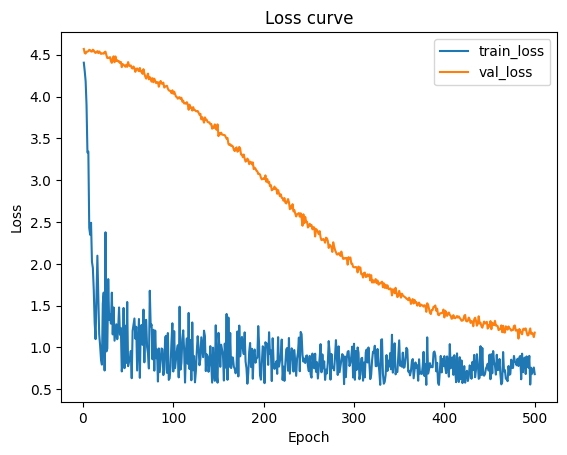

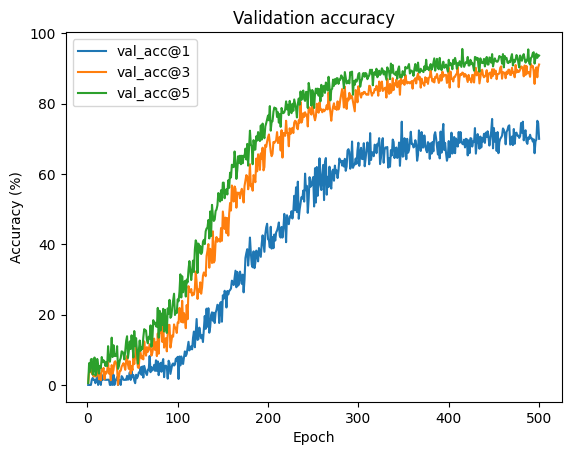

In [24]:

# –ó–∞–≥—Ä—É–∑–∫–∞ –ª—É—á—à–µ–≥–æ —á–µ–∫–ø–æ–∏–Ω—Ç–∞ –≤ EMA-–º–æ–¥–µ–ª—å –∏ —Ñ–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ Test
state = torch.load("models/best_rus_model.pth", map_location=device)
model_ema.ema.load_state_dict(state)

@torch.no_grad()
def evaluate_test():
    model_to_eval = model_ema.ema
    model_to_eval.eval()

    total_loss = 0.0
    acc1_metric_test.reset()
    acc3_metric_test.reset()
    acc5_metric_test.reset()

    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        out = model_to_eval(x)
        loss = F.cross_entropy(out, y)
        total_loss += loss.item() * x.size(0)

        acc1_metric_test.update(out, y)
        acc3_metric_test.update(out, y)
        acc5_metric_test.update(out, y)

    n = len(test_loader.dataset)
    test_loss = total_loss / n
    test_acc1 = acc1_metric_test.compute().item() * 100.0
    test_acc3 = acc3_metric_test.compute().item() * 100.0
    test_acc5 = acc5_metric_test.compute().item() * 100.0
    return test_loss, test_acc1, test_acc3, test_acc5

test_loss, test_acc1, test_acc3, test_acc5 = evaluate_test()
print(f"üìä Test: loss={test_loss:.4f}  acc@1={test_acc1:.2f}%  acc@3={test_acc3:.2f}%  acc@5={test_acc5:.2f}%")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ª—É—á—à–∏–π –≤–µ—Å–æ–≤–æ–π —Ñ–∞–π–ª –æ—Ç–¥–µ–ª—å–Ω–æ
final_weights_path = "models/rus_byclass_best_ema.pth"
torch.save(model_ema.ema.state_dict(), final_weights_path)
print("üíæ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ:", final_weights_path)

# –ì—Ä–∞—Ñ–∏–∫–∏ (–æ–¥–∏–Ω–æ—á–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫ –Ω–∞ –º–µ—Ç—Ä–∏–∫—É, –±–µ–∑ seaborn, –±–µ–∑ —Ü–≤–µ—Ç–æ–≤)
epochs = train_history["epoch"]
plt.figure()
plt.plot(epochs, train_history["train_loss"], label="train_loss")
plt.plot(epochs, train_history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.show()

plt.figure()
plt.plot(epochs, train_history["val_acc1"], label="val_acc@1")
plt.plot(epochs, train_history["val_acc3"], label="val_acc@3")
plt.plot(epochs, train_history["val_acc5"], label="val_acc@5")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation accuracy")
plt.show()


In [25]:

from PIL import Image
@torch.no_grad()
def predict_image(path: str) -> Tuple[int, np.ndarray]:
    model_ema.ema.eval()
    img = Image.open(path).convert("L")  # grayscale
    if cfg.fix_emnist_orientation:
        img = fix_emnist(img)
    img = img.resize((cfg.img_size, cfg.img_size))
    x = transforms.ToTensor()(img)
    x = transforms.Normalize(IMAGENET_GRAY_MEAN, IMAGENET_GRAY_STD)(x)
    x = x.unsqueeze(0).to(device)
    logits = model_ema.ema(x)
    probs = logits.softmax(dim=1).cpu().numpy()[0]
    pred = int(probs.argmax())
    return pred, probs

print("–ì–æ—Ç–æ–≤–æ –∫ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å—É: –∏—Å–ø–æ–ª—å–∑—É–π—Ç–µ predict_image('/path/to/img.png')")


–ì–æ—Ç–æ–≤–æ –∫ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å—É: –∏—Å–ø–æ–ª—å–∑—É–π—Ç–µ predict_image('/path/to/img.png')


In [26]:
test_acc3

71.34989500045776